# Cancer Cell Lines Enriched Loci: Fisher Analysis
The goal in this notebook is to identify smRNA loci that are enriched in cancerous cell lines, but not in normal cell lines via Fisher Exact Test based analysis.

In [1]:
import pandas as pd
import numpy as np
from statsmodels.stats.multitest import fdrcorrection
import scipy.stats as stats
import statsmodels
import seaborn as sns
import random
import json as js
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Load Counts

In [2]:
with open('data/counts/cell_lines_cpm_map.json', 'r') as f:
    cpm_map = js.load(f)
    f.close()
with open('data/counts/cell_lines_loci_counts.json', 'r') as f:
    sample_loci = js.load(f)
    f.close()

## HUMEC Filter
Here we filter out all the loci present in the HUMEC (normal) cell lines.

In [3]:
humec_loci = set()
for cell_line, loci_dict in sample_loci.items():
    if "HUMEC" in cell_line:
        humec_loci.update(loci_dict.keys())
len(humec_loci)

373352

In [4]:
hu_fil_sample_loci = {}
for cell_line, loci_dict in sample_loci.items():
    hu_fil_sample_loci[cell_line] = {}
    for locus, count in loci_dict.items():
        if locus not in humec_loci:
            hu_fil_sample_loci[cell_line][locus] = count

In [5]:
#Unique loci after healthy exRNA filtering
all_loci = set()
for cell_line, loci_dict in sample_loci.items():
    all_loci.update(loci_dict.keys())
print("Number of unqiue loci in all cell lines post exRNA filtering:", len(all_loci))

Number of unqiue loci in all cell lines post exRNA filtering: 1459094


In [6]:
#Unique loci after healthy cell lines and health exRNA filtering
cancer_loci = {}
for cell_line, loci_dict in hu_fil_sample_loci.items():
    for locus in loci_dict:
        if locus in cancer_loci:
            cancer_loci[locus] += 1
        else:
            cancer_loci[locus] = 1
print("Number of unqiue loci in cancer cell lines :", len(cancer_loci))

Number of unqiue loci in cancer cell lines : 1085742


## Fisher Exact Test

In [7]:
loci_pval= {}
for locus in cancer_loci:
    test_count = cancer_loci[locus]
    ctrl_count = 0 #We already filtered out all loci in the normal HUMEC cell lines
    oddsratio, pvalue = stats.fisher_exact([[test_count, ctrl_count],[18-test_count, 3]], "greater") #There are 18 non-normal cell lines
    loci_pval[locus] = pvalue

In [8]:
loci_pval_df = pd.DataFrame.from_dict(loci_pval, orient="index", columns=["pval"])
loci_pval_df.head()

,pval
chr1:20315-20341:-,0.857143
chr1:102305-102322:+,0.857143
chr1:175693-175731:-,0.857143
chr1:198533-198571:-,0.728571
chr1:265557-265580:-,0.857143


In [9]:
rej, fdr = fdrcorrection(loci_pval_df["pval"], alpha=0.1)
loci_pval_df["fdr"] = fdr
print("Num sig pval:", loci_pval_df[loci_pval_df["pval"] <= 0.1].shape[0])
print("Num sig fdr", loci_pval_df[loci_pval_df["fdr"] <= 0.1].shape[0])

Num sig pval: 771
Num sig fdr 0


In [10]:
sig_loci = loci_pval_df[loci_pval_df["pval"] <= 0.1]

## Create Expression Matrix for Visualization

In [11]:
#Create df for heatmap visualization
loci_exp = {}
loci_binary = {}

for locus in sig_loci.index:
    loci_exp[locus] = {}
    loci_binary[locus] = {} 

    for cell_line, loci_dict in hu_fil_sample_loci.items():
        if locus in loci_dict:
            loci_exp[locus][cell_line] = loci_dict[locus] * cpm_map[cell_line] #Transform raw count to cpm. Note we use the cpm_map from non ex-filtered dataset to capture whole count.
            loci_binary[locus][cell_line] = 1
        else:
            loci_exp[locus][cell_line] = 0
            loci_binary[locus][cell_line] = 0

In [12]:
loci_exp_df = pd.DataFrame.from_dict(loci_exp, orient="index")
loci_binary_df = pd.DataFrame.from_dict(loci_binary, orient="index")

In [13]:
subtype_map = {"MDA453":"HER2+", "SKBR-3":"HER2+", 
              "HUMEC":"Normal", "ZR75-1":"Luminal", "HCC38": "TNBC",
              "CN34":"TNBC", "MCF7": "Luminal", "MDA231":"TNBC", 
              "LM2":"Met", "LM1a":"Met"}

## Binary Heatmap of Significant Loci

In [14]:
colData = pd.DataFrame(loci_binary_df.columns, columns=["Sample"]) #Sample column contains all the samples
colData["Cell Line"] = colData["Sample"].apply(lambda x: x.split("_")[0]) #From sample name, get cell line information
colData["Subtype"] = colData["Cell Line"].apply(lambda x: subtype_map[x]) #Base on cell line, map to subtype category
colData = colData.sort_values("Cell Line").sort_values("Subtype") #First sort by cell line then by subtype
colData = pd.concat([colData[colData["Subtype"] == "Normal"], colData[colData["Subtype"] != "Normal"]]).copy()
colData = colData.set_index("Subtype", drop=False)

colors = sns.color_palette("Paired", len(colData["Subtype"].unique()))
random.shuffle(colors)
lut = dict(zip(list(colData["Subtype"].unique()), colors))
col_colors = colData["Subtype"].map(lut)

In [15]:
loci_binary_df = loci_binary_df[list(colData["Sample"])]
loci_binary_df.columns = colData["Subtype"]

/rumi/shams/jwang/anaconda3/envs/smRNA/lib/python3.7/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


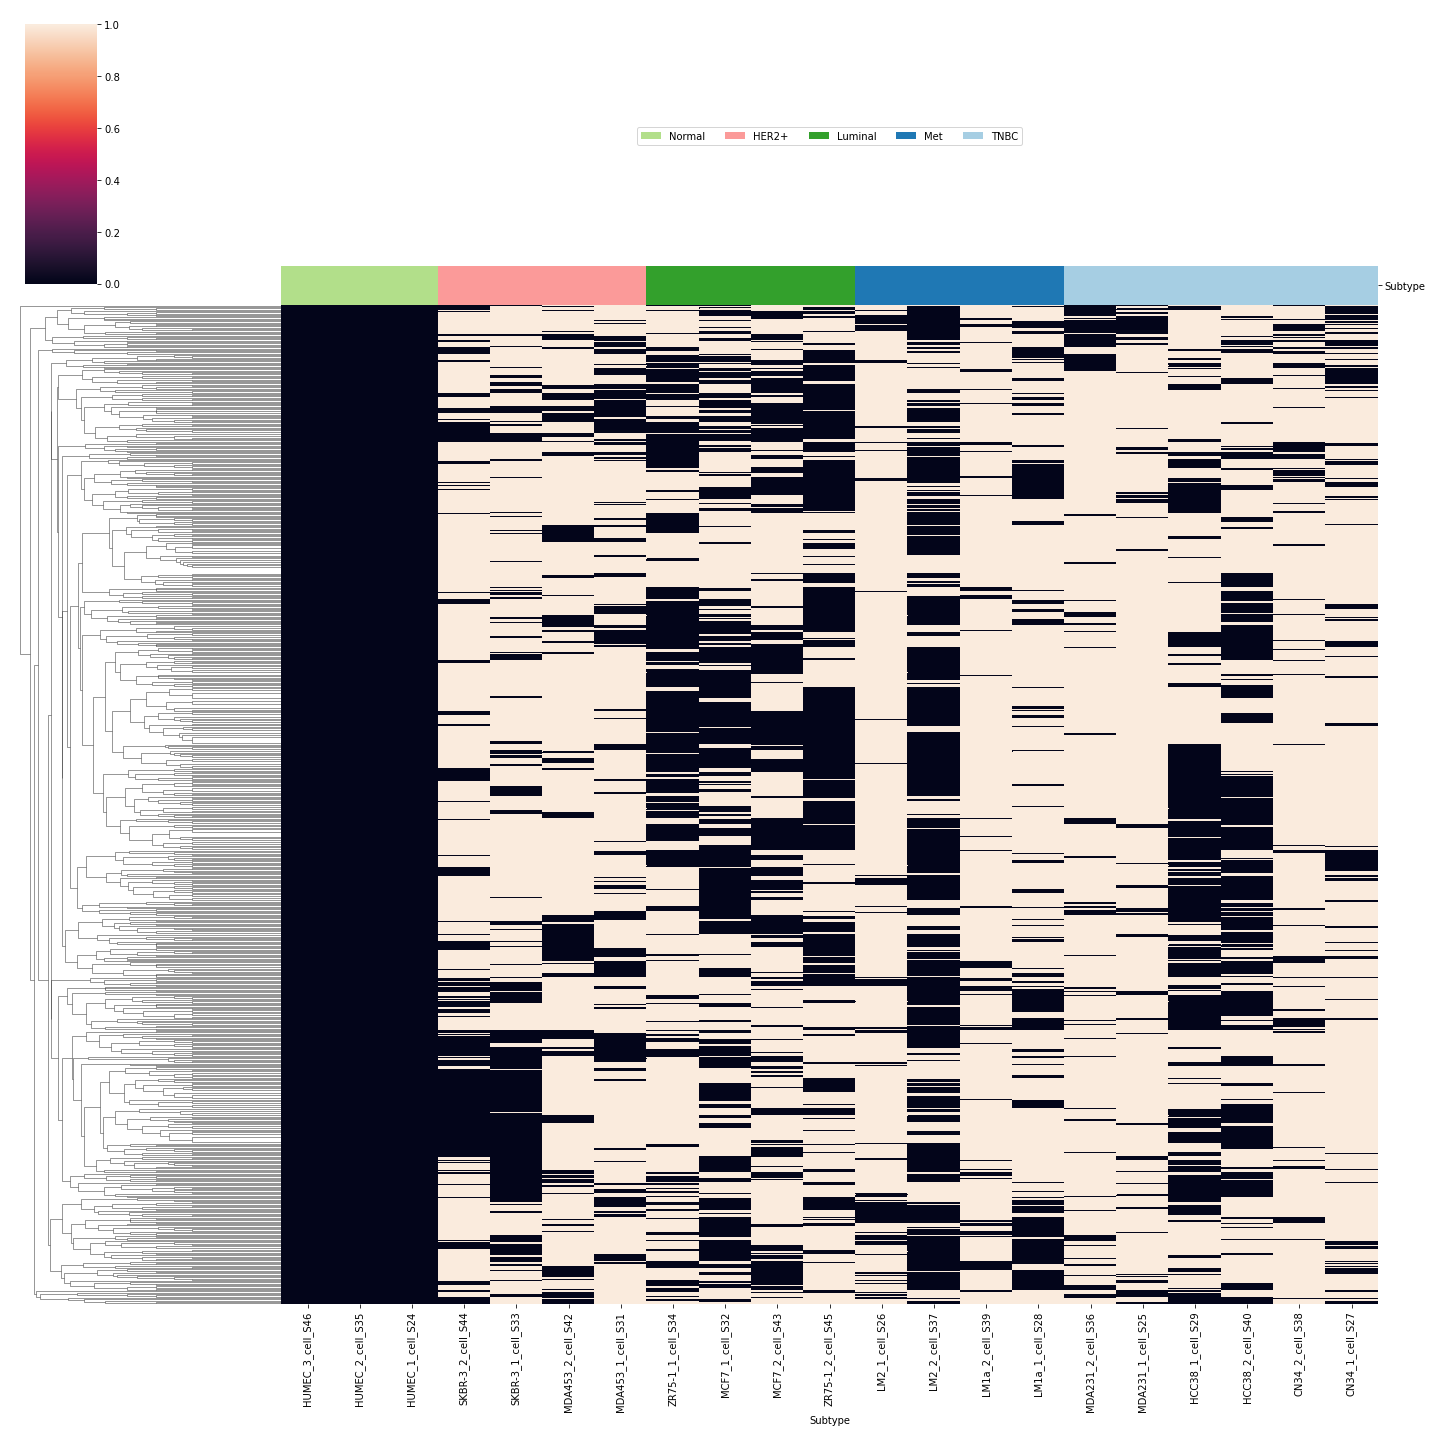

In [16]:
g=sns.clustermap(loci_binary_df,figsize=(20,20), col_cluster=False, col_colors=col_colors, yticklabels=False, xticklabels=colData["Sample"])
for label in colData["Subtype"].unique():
    g.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)
    
g.ax_col_dendrogram.legend(loc="center", ncol=5)
g.savefig("figures/cell_lines_sig_binary_loci_fisher_heatmap.pdf")

## Expression Heatmap of Significant Loci

In [17]:
#Max norm for visualization
loci_df = np.zeros(loci_exp_df.shape)
for i in range(loci_exp_df.shape[0]):
    max_per_row = np.max(loci_exp_df.iloc[i])
    loci_df[i] = np.divide(loci_exp_df.iloc[i], max_per_row) #Max-norm

In [18]:
loci_df = pd.DataFrame(loci_df, index=loci_exp_df.index, columns=loci_exp_df.columns)
loci_df = loci_df[list(colData["Sample"])] #Set columns to match colData order
loci_df.columns = colData["Subtype"]

/rumi/shams/jwang/anaconda3/envs/smRNA/lib/python3.7/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 1440x1440 with 0 Axes>

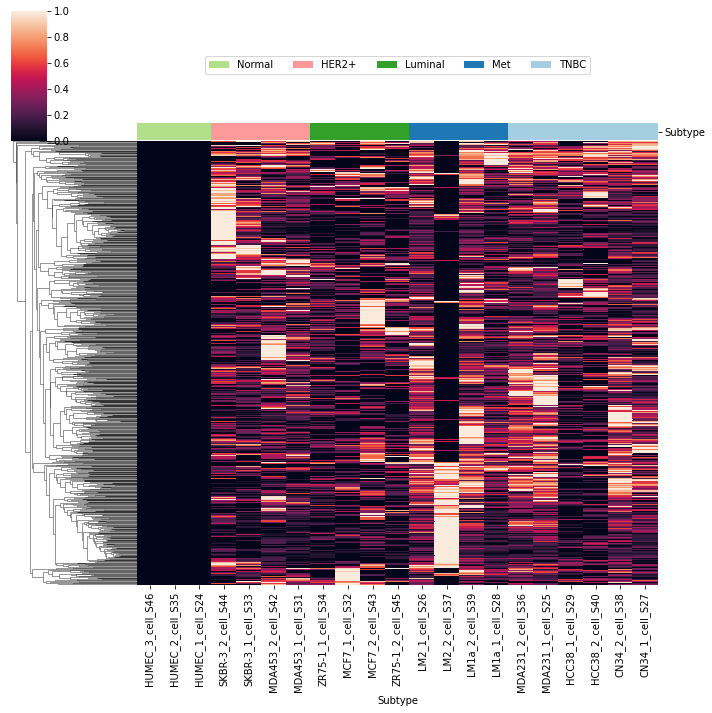

In [19]:
plt.figure(figsize=(20,20))
g=sns.clustermap(loci_df, col_cluster=False, col_colors=col_colors,yticklabels=False, xticklabels=colData["Sample"], method="average")
for label in colData["Subtype"].unique():
    g.ax_col_dendrogram.bar(0, 0, color=lut[label],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=5)
g.savefig("figures/cell_lines_sig_loci_fisher_heatmap.pdf")

## Save Cell Lines Significant Loci


In [20]:
with open("results/fisher/cell_lines_sig_loci_fisher.bed", "wt") as out:   
    for locus in sig_loci.index:
        splits = locus.split(":")
        start = splits[1].split("-")[0]
        end = splits[1].split("-")[1]
        bed = f"{splits[0]}\t{start}\t{end}\t{locus}\t.\t{splits[-1]}"
        out.write(bed + "\n")

In [21]:
loci_pval_df.to_csv("results/fisher/cell_lines_loci_fisher_res.csv")

# Done